In [1]:
from src.scm.ncm.time_causal_vae import C_VAE

latent_dim = 64
input_dim = 25
seq_length = 5000
batch_size = 300

num_flows = 5 
hidden_dim = 128 

model = C_VAE(
            latent_dim=latent_dim,
            input_dim=input_dim,
            seq_length=seq_length,
            batch_size=batch_size,
            prior=5,
            device="cpu"
        )


In [2]:
import torch as T

ckpt_path = "model_weights/c_vae/financial_vae/financial_vae-epoch=999-val_loss=0.10.ckpt"
checkpoint = T.load(ckpt_path, map_location="cpu")
new_state_dict = {}
for key in checkpoint['state_dict'].keys():
    new_key = key.replace("vae.", "")
    new_state_dict[new_key] = checkpoint['state_dict'][key]

# Then replace the old state_dict with the new one
checkpoint['state_dict'] = new_state_dict

model.load_state_dict(checkpoint['state_dict'])

C:\Users\luiso\AppData\Local\Temp\ipykernel_15352\586088630.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = T.load(ckpt_path, map_location="cpu")


<All keys matched successfully>

In [3]:
import numpy as np
import pandas as pd

data = pd.read_csv("FinanceCPT/returns/random-rels_20_1A_returns30007000.csv", header=None)

In [4]:
window_size = 20

windows = np.lib.stride_tricks.sliding_window_view(data.values, (window_size, data.shape[1]))

# Reshape to (num_windows, window_size, num_features)
windows = windows.reshape(-1, window_size, data.shape[1])

In [5]:
n_samples = 3981
ran_samp = model.sample(n_samples, 20).detach().numpy()

In [6]:
ran_samp.shape, windows.shape

((3981, 20, 25), (3981, 20, 25))

In [7]:
# Expected Value

t_step = 14
dim = 3

np.mean(windows[:,t_step,dim]), np.mean(ran_samp[:,t_step,dim])

(np.float64(0.04056833116345391), np.float32(0.02040797))

In [14]:
from scipy.stats import entropy

bins = 10

temp_1 = 0
temp_2 = 0
t_step = 12
#dim = 15

n_samples = 3981
n_steps = 20

matrix = np.zeros((n_steps, 25))

#ctf_samp = model.ctf_decoder(do, n_samples, n_steps)
ran_samp = model.sample(n_samples, n_steps).detach().numpy()

# 25 dimensions in this dataset
for dim in range(25):
    temp_1 = 0
    for idx in range(n_steps):
        #f_val_ori = [i["Y1"].iloc[idx] for i in CDML_dfs]
        #f_val_sam = ran_samp["Y1"][:,idx,0].detach().numpy()

        f_val_ori = windows[:,idx,dim]
        f_val_sam = ran_samp[:,idx,dim]

        p_hist, _ = np.histogram(f_val_ori, bins=bins, density=True)
        q_hist, _ = np.histogram(f_val_sam, bins=bins, density=True)

        # Add a small constant to avoid division by zero and log(0)
        epsilon = 1e-10
        p_hist += epsilon
        q_hist += epsilon

        # Normalize histograms to ensure they sum to 1
        p_hist /= np.sum(p_hist)
        q_hist /= np.sum(q_hist)

        # Compute KL divergence
        kl_div_pq = entropy(p_hist, q_hist)  # D_KL(P || Q)
        kl_div_qp = entropy(q_hist, p_hist)  # D_KL(Q || P)

        #print(kl_div_pq)

        #temp_1 += kl_div_pq

        #matrix[idx, dim] = temp_1
        matrix[idx, dim] = kl_div_pq

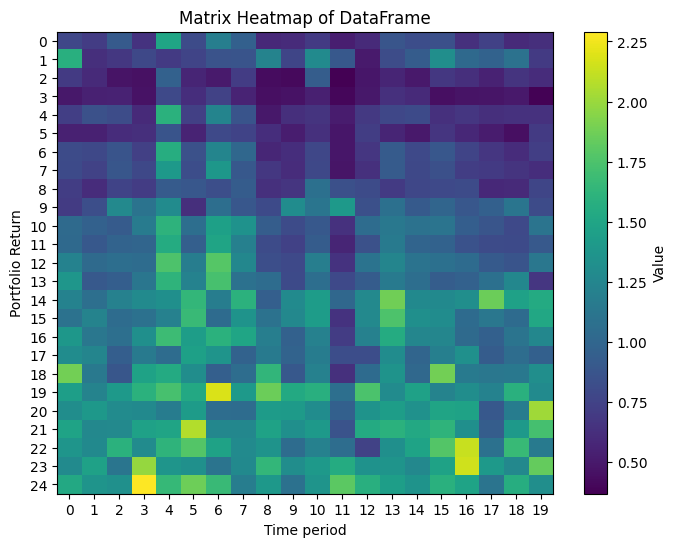

In [17]:
import matplotlib.pyplot as plt

df = pd.DataFrame(matrix)
plt.figure(figsize=(8, 6))
plt.imshow(df.T, aspect='auto', cmap='viridis')  # transpose so columns on y-axis
plt.colorbar(label='Value')
plt.yticks(ticks=np.arange(len(df.columns)), labels=df.columns)
plt.xticks(ticks=np.arange(len(df)), labels=df.index)
plt.xlabel('Time period')
plt.ylabel('Portfolio Return')
plt.title('Matrix Heatmap of DataFrame')
plt.show()